# Lesson 7. Attribute and Spatial Joins

Now that we understand the logic of spatial relationship queries,
let's take a look at another fundamental spatial operation that relies on them.

This operation, called a **spatial join**, is the process by which we can
leverage the spatial relationships between distinct datasets to merge
their information into a new, synthetic dataset.

This operation can be thought as the spatial equivalent of an
**attribute join**, in which multiple tabular datasets can be merged by
aligning matching values in a common column that they both contain.
Thus, we'll start by developing an understanding of this operation first!

- 7.0 Data Input and Prep
- 7.1 Attribute Joins
- **Exercise**: Choropleth Map
- 7.2 Spatial Joins
- 7.3 Aggregation
- **Exercise**: Aggregation
- **Exercise**: Full Workflow

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# get the solution hider
from solution_hider import hide_solution

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

# 7.0 Data Input and Prep

Let's read in a table of data from the US Census' 5-year American Community Survey (ACS5).

In [2]:
# Read in the ACS5 data for CA into a pandas DataFrame.
# Note: We force the FIPS_11_digit to be read in as a string to preserve any leading zeroes.
acs5_df = pd.read_csv("notebook_data/census/ACS5yr/census_variables_CA.csv", dtype={'FIPS_11_digit':str})
acs5_df.head()

,NAME,c_race,c_white,c_black,c_asian,c_latinx,c_race_moe,c_white_moe,c_black_moe,c_asian_moe,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,"Census Tract 4012, Alameda County, California",2456,1287,476,259,283,213,191,116,124,...,0.814951,0.103350,0.058415,0.010212,0.013072,0.551370,0.064384,0.189041,0.083562,0.058219
1,"Census Tract 4013, Alameda County, California",3983,845,1348,827,796,680,186,411,283,...,0.611865,0.280040,0.063348,0.022624,0.022122,0.341153,0.108993,0.391496,0.018084,0.104594
2,"Census Tract 4014, Alameda County, California",4340,713,1902,593,981,644,314,440,198,...,0.807683,0.163739,0.017803,0.006325,0.004451,0.470846,0.021317,0.255799,0.116614,0.102194
3,"Census Tract 4015, Alameda County, California",2080,563,1064,215,190,369,222,283,116,...,0.841346,0.101442,0.053846,0.003365,0.000000,0.502037,0.090631,0.230143,0.047862,0.017312
4,"Census Tract 4016, Alameda County, California",1889,324,960,247,274,400,135,376,164,...,0.830645,0.079570,0.082258,0.002151,0.005376,0.570481,0.122720,0.177446,0.063018,0.000000


**Brief summary of the data**:

Below is a table of the variables in this table. They were combined from 
different ACS 5 year tables.

<u>NOTE</u>:
- variables that start with `c_` are counts
- variables that start with `med_` are medians
- variables that end in `_moe` are margin of error estimates
- variables that start with `_p` are proportions calcuated from the counts divided by the table denominator (the total count for whom that variable was assessed)


| Variable        | Description                                     |
|-----------------|-------------------------------------------------|
|`c_race`         |Total population                                 
|`c_white`        |Total white non-Latinx
| `c_black`       | Total black and African American non-Latinx
| `c_asian`       | Total Asian non-Latinx
| `c_latinx`      | Total Latinx
| `state_fips`    | State level FIPS code
| `county_fips`   | County level FIPS code
| `tract_fips`    |Tracts level FIPS code
| `med_rent`      |Median rent
| `med_hhinc`     |Median household income
| `c_tenants`     |Total tenants
| `c_owners`      |Total owners
| `c_renters`     |Total renters
| `c_movers`      |Total number of people who moved
| `c_stay`        |Total number of people who stayed
| `c_movelocal`   |Number of people who moved locally
| `c_movecounty`  |Number of people who moved counties
| `c_movestate`   | Number of people who moved states
| `c_moveabroad`  |Number of people who moved abroad
| `c_commute`     |Total number of commuters
| `c_car`         | Number of commuters who use a car
| `c_carpool`     | Number of commuters who carpool
| `c_transit`     |Number of commuters who use public transit
| `c_bike`        |Number of commuters who bike
| `c_walk`        |Number of commuters who bike
| `year`          | ACS data year
| `FIPS_11_digit` | 11-digit FIPS code


We're going to drop all of our `moe` columns by identifying all of those that end with `_moe`. We can do that in two steps, first by using `filter` to identify columns that contain the string `_moe`.

In [3]:
moe_cols = acs5_df.filter(like='_moe',axis=1).columns
moe_cols

Index(['c_race_moe', 'c_white_moe', 'c_black_moe', 'c_asian_moe',
       'c_latinx_moe', 'med_rent_moe', 'med_hhinc_moe', 'c_tenants_moe',
       'c_owners_moe', 'c_renters_moe', 'c_movers_moe', 'c_stay_moe',
       'c_movelocal_moe', 'c_movecounty_moe', 'c_movestate_moe',
       'c_moveabroad_moe', 'c_commute_moe', 'c_car_moe', 'c_carpool_moe',
       'c_transit_moe', 'c_bike_moe', 'c_walk_moe'],
      dtype='object')

In [4]:
acs5_df.drop(moe_cols, axis=1, inplace=True)

And lastly, let's grab only the rows for year 2018 and county FIPS code 1 (i.e. Alameda County)

In [5]:
acs5_df_ac = acs5_df[(acs5_df['year']==2018) & (acs5_df['county_fips']==1)]

---------------------------------
Now let's also read in our census tracts again!

In [6]:
tracts_gdf = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")

In [7]:
tracts_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8..."
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((-122.30403 37.80739, -122.30239 37.8..."
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((-122.27598 37.80622, -122.27335 37.8..."
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((-122.21825 37.80086, -122.21582 37.8..."


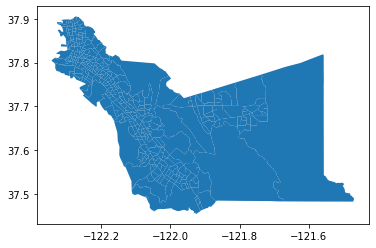

In [8]:
tracts_gdf_ac = tracts_gdf[tracts_gdf['COUNTYFP']=='001']
tracts_gdf_ac.plot()
plt.show()

# 7.1 Attribute Joins

**Attribute Joins  between Geodataframes and  Dataframes**

*We just mapped the census tracts. But what makes a map powerful is when you map the data associated with the locations.*

- `tracts_gdf_ac`: These are polygon data in a GeoDataFrame. However, as we saw in the `head` of that dataset, they no attributes of interest!

- `acs5_df_ac`: These are 2018 ACS data from a CSV file ('census_variables_CA.csv'), imported and read in as a `pandas` DataFrame. However, they have no geometries!

In order to map the ACS data we need to associate it with the tracts. Let's do that now, by joining the columns from `acs5_df_ac` to the columns of `tracts_gdf_ac` using a common column as the key for matching rows. This process is called an **attribute join**.






--------------------------

<img src="https://documentation.mindsphere.io/resources/html/predictive-learning/en-US/Joins_Diagram.png">


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

The image above gives us a nice conceptual summary of the types of joins we could run.

1. In general, why might we choose one type of join over another?
1. In our case, do we want an inner, left, right, or outer (AKA 'full') join? 

(**NOTE**: You can read more about merging in `geopandas` [here](http://geopandas.org/mergingdata.html#attribute-joins).)

Okay, here we go!

Let's take a look at the common column in both our DataFrames.


In [9]:
tracts_gdf_ac['GEOID'].head()

0    06001400300
1    06001400900
2    06001402200
3    06001402800
4    06001404800
Name: GEOID, dtype: object

In [10]:
acs5_df_ac['FIPS_11_digit'].head()

8323    06001441501
8324    06001404700
8325    06001442500
8326    06001450300
8327    06001450607
Name: FIPS_11_digit, dtype: object


Note that they are **not named the same thing**. 
        
        That's okay! We just need to know that they contain the same information.

Also note that they are **not in the same order**. 
        
        That's not only okay... That's the point! (If they were in the same order already then we could just join them side by side, without having Python find and line up the matching rows from each!)

-------------------------------

Let's do a `left` join to keep all of the census tracts in Alameda County and only the ACS data for those tracts.

**NOTE**: To figure out how to do this we could always take a peek at the documentation by calling
`?tracts_gdf_ac.merge`, or `help(tracts_gdf_ac)`.

In [11]:
# Left join keeps all tracts and the acs data for those tracts
tracts_acs_gdf_ac = tracts_gdf_ac.merge(acs5_df_ac, left_on='GEOID',right_on="FIPS_11_digit", how='left')
tracts_acs_gdf_ac.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_x,LSAD,ALAND,AWATER,geometry,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8...",...,0.840542,0.045069,0.058407,0.031528,0.024454,0.420840,0.059496,0.280672,0.067899,0.057479
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8...",...,0.906161,0.065687,0.005712,0.022440,0.000000,0.555718,0.068915,0.213343,0.060850,0.044721


Let's check that we have all the variables we have in our dataset now.

In [12]:
list(tracts_acs_gdf_ac.columns)

['STATEFP',
 'COUNTYFP',
 'TRACTCE',
 'AFFGEOID',
 'GEOID',
 'NAME_x',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry',
 'NAME_y',
 'c_race',
 'c_white',
 'c_black',
 'c_asian',
 'c_latinx',
 'state_fips',
 'county_fips',
 'tract_fips',
 'med_rent',
 'med_hhinc',
 'c_tenants',
 'c_owners',
 'c_renters',
 'c_movers',
 'c_stay',
 'c_movelocal',
 'c_movecounty',
 'c_movestate',
 'c_moveabroad',
 'c_commute',
 'c_car',
 'c_carpool',
 'c_transit',
 'c_bike',
 'c_walk',
 'year',
 'FIPS_11_digit',
 'p_white',
 'p_black',
 'p_asian',
 'p_latinx',
 'p_owners',
 'p_renters',
 'p_stay',
 'p_movelocal',
 'p_movecounty',
 'p_movestate',
 'p_moveabroad',
 'p_car',
 'p_carpool',
 'p_transit',
 'p_bike',
 'p_walk']

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

It's always important to run sanity checks on our results, at each step of the way!

In this case, how many rows and columns should we have?


In [13]:
print("Rows and columns in the Alameda County Census tract gdf:\n\t", tracts_gdf_ac.shape)
print("Row and columns in the ACS5 2018 data:\n\t", acs5_df_ac.shape)
print("Rows and columns in the Alameda County Census tract gdf joined to the ACS data:\n\t", tracts_acs_gdf_ac.shape)

Rows and columns in the Alameda County Census tract gdf:
	 (361, 10)
Row and columns in the ACS5 2018 data:
	 (361, 44)
Rows and columns in the Alameda County Census tract gdf joined to the ACS data:
	 (361, 54)


Let's save out our merged data so we can use it in the final notebook.

In [14]:
tracts_acs_gdf_ac.to_file('outdata/tracts_acs_gdf_ac.json', driver='GeoJSON')

## Exercise: Choropleth Map
We can now make choropleth maps using our attribute joined geodataframe. Go ahead and pick one variable to color the map, then map it. You can go back to lesson 5 if you need a refresher on how to make this!

See the plot below for an example.

**To see the solution, click the button.**

In [15]:
# YOUR CODE HERE






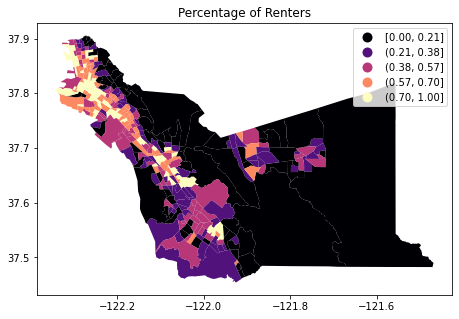

In [16]:
# SOLUTION:
fig, ax = plt.subplots(figsize = (10,5)) 
tracts_acs_gdf_ac.plot(column='p_renters', 
                   scheme="quantiles",
                   legend=True,
                   ax=ax,cmap='magma'
                   )
ax.set_title("Percentage of Renters")

hide_solution()

-------------------
# 7.2 Spatial Joins

Great! We've wrapped our heads around the concept of an attribute join.

Now let's extend that concept to its spatially explicit equivalent: the **spatial join**!


<br>

To start, we'll read in some other data: The Alameda County schools data.

Then we'll work with that data and our `tracts_acs_gdf_ac` data together.

In [17]:
schools_df = pd.read_csv('notebook_data/alco_schools.csv')
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
schools_gdf.crs = "epsg:4326"

Let's check if we have to transform the schools to match the`tracts_acs_gdf_ac`'s CRS.

In [19]:
print('schools_gdf CRS:', schools_gdf.crs)
print('tracts_acs_gdf_ac CRS:', tracts_acs_gdf_ac.crs)

schools_gdf CRS: epsg:4326
tracts_acs_gdf_ac CRS: epsg:4269


Yes we do! Let's do that.

**NOTE**: Explicit syntax aiming at that dataset's CRS leaves less room for human error!

In [21]:
schools_gdf = schools_gdf.to_crs(tracts_acs_gdf_ac.crs)

print('schools_gdf CRS:', schools_gdf.crs)
print('tracts_acs_gdf_ac CRS:', tracts_acs_gdf_ac.crs)

schools_gdf CRS: epsg:4269
tracts_acs_gdf_ac CRS: epsg:4269


Now we're ready to combine the datasets in an analysis.

**In this case, we want to get data from the census tract within which each school is located.**

But how can we do that? The two datasets don't share a common column to use for a join.

In [22]:
tracts_acs_gdf_ac.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME_x', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'NAME_y', 'c_race', 'c_white', 'c_black',
       'c_asian', 'c_latinx', 'state_fips', 'county_fips', 'tract_fips',
       'med_rent', 'med_hhinc', 'c_tenants', 'c_owners', 'c_renters',
       'c_movers', 'c_stay', 'c_movelocal', 'c_movecounty', 'c_movestate',
       'c_moveabroad', 'c_commute', 'c_car', 'c_carpool', 'c_transit',
       'c_bike', 'c_walk', 'year', 'FIPS_11_digit', 'p_white', 'p_black',
       'p_asian', 'p_latinx', 'p_owners', 'p_renters', 'p_stay', 'p_movelocal',
       'p_movecounty', 'p_movestate', 'p_moveabroad', 'p_car', 'p_carpool',
       'p_transit', 'p_bike', 'p_walk'],
      dtype='object')

In [23]:
schools_gdf.columns

Index(['X', 'Y', 'Site', 'Address', 'City', 'State', 'Type', 'API', 'Org',
       'geometry'],
      dtype='object')

However, they do have a shared relationship by way of space! 

So, we'll use a spatial relationship query to figure out the census tract that
each school is in, then associate the tract's data with that school (as additional data in the school's row).
This is a **spatial join**!

---------------------------------

### Census Tract Data Associated with Each School

In this case, let's say we're interested in the relationship between the median household income
in a census tract (`tracts_acs_gdf_ac['med_hhinc']`) and a school's Academic Performance Index
(`schools_gdf['API']`).

To start, let's take a look at the distributions of our two variables of interest.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8745d4d8b0>]],
      dtype=object)

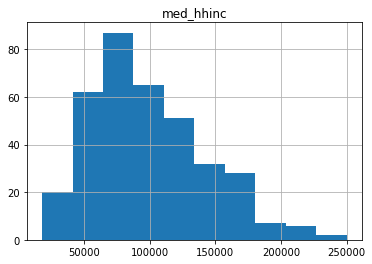

In [24]:
tracts_acs_gdf_ac.hist('med_hhinc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8745daaca0>]],
      dtype=object)

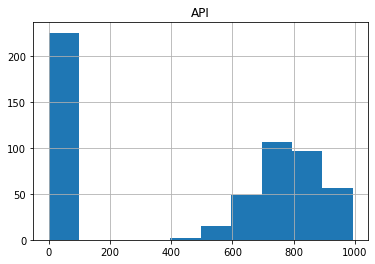

In [25]:
schools_gdf.hist('API')

Oh, right! Those pesky schools with no reported APIs (i.e. API == 0)! Let's drop those.

In [26]:
schools_gdf_api = schools_gdf.loc[schools_gdf['API'] > 0, ]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8746192040>]],
      dtype=object)

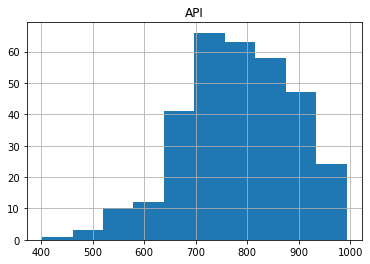

In [27]:
schools_gdf_api.hist('API')

Much better!

Now, maybe we think there ought to be some correlation between the two variables?
As a first pass at this possibility, let's overlay the two datasets, coloring each one by
its variable of interest. This should give us a sense of whether or not similar values co-occur.

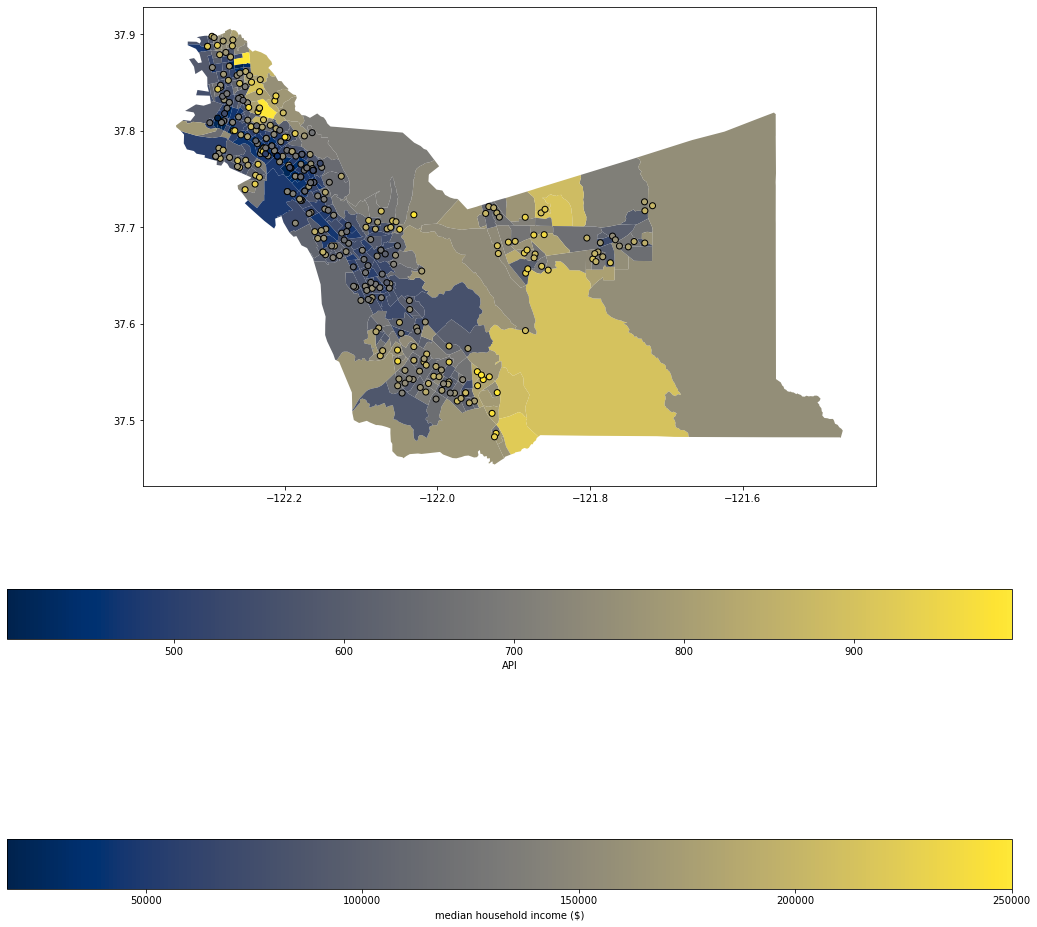

In [28]:
ax = tracts_acs_gdf_ac.plot(column='med_hhinc', cmap='cividis', figsize=[18,18],
                            legend=True, legend_kwds={'label': "median household income ($)",
                                                      'orientation': "horizontal"})
schools_gdf_api.plot(column='API', cmap='cividis', edgecolor='black', alpha=1, ax=ax,
                     legend=True, legend_kwds={'label': "API", 'orientation': "horizontal"})

### Spatially Joining our Schools and Census Tracts

Though it's hard to say for sure, it certainly looks possible.
It would be ideal to scatterplot the variables! But in order to do that, 
we need to know the median household income in each school's tract, which
means we definitely need our **spatial join**!

We'll first take a look at the documentation for the spatial join function, `gpd.sjoin`.

In [29]:
help(gpd.sjoin)

Help on function sjoin in module geopandas.tools.sjoin:

sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    Spatial join of two GeoDataFrames.
    
    Parameters
    ----------
    left_df, right_df : GeoDataFrames
    how : string, default 'inner'
        The type of join:
    
        * 'left': use keys from left_df; retain only left_df geometry column
        * 'right': use keys from right_df; retain only right_df geometry column
        * 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column
    op : string, default 'intersects'
        Binary predicate, one of {'intersects', 'contains', 'within'}.
        See http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates.
    lsuffix : string, default 'left'
        Suffix to apply to overlapping column names (left GeoDataFrame).
    rsuffix : string, default 'right'
        Suffix to apply to overlapping column names (right GeoDataFrame).



Looks like the key arguments to consider are:
- the two GeoDataFrames (**`left_df`** and **`right_df`**)
- the type of join to run (**`how`**), which can take the values `left`, `right`, or `inner`
- the spatial relationship query to use (**`op`**)

**NOTE**:
- By default `sjoin` is an inner join. It keeps the data from both geodataframes only where the locations spatially intersect.

- By default `sjoin` maintains the geometry of first geodataframe input to the operation. 


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. Which GeoDataFrame are we joining onto which (i.e. which one is getting the other one's data added to it)?
1. What happened to 'outer' as a join type?
1. Thus, in our operation, which GeoDataFrame should be the `left_df`, which should be the `right_df`, and `how` do we want our join to run?

Alright! Let's run our join!

In [30]:
schools_jointracts = gpd.sjoin(schools_gdf_api, tracts_acs_gdf_ac, how='left')

### Checking Our Output

<br>

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

As always, we want to sanity-check our intermediate result before we rush ahead.

One way to do that is to introspect the structure of the result object a bit.

1. What type of object should that have given us?
1. What should the dimensions of that object be, and why?
1. If we wanted a visual check of our results (i.e. a plot or map), what could we do?

In [31]:
print(schools_jointracts.shape)
print(schools_gdf.shape)
print(tracts_acs_gdf_ac.shape)

(325, 64)
(550, 10)
(361, 54)


In [32]:
schools_jointracts.head()

,X,Y,Site,Address,City,State,Type,API,Org,geometry,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public,POINT (-122.23876 37.74476),...,0.901694,0.053120,0.013314,0.023534,0.008338,0.680745,0.077650,0.107293,0.004722,0.019150
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public,POINT (-122.25186 37.73900),...,0.901694,0.053120,0.013314,0.023534,0.008338,0.680745,0.077650,0.107293,0.004722,0.019150
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public,POINT (-122.25892 37.76206),...,0.845120,0.090240,0.032640,0.032000,0.000000,0.601057,0.042933,0.247028,0.033025,0.011889
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public,POINT (-122.23484 37.76525),...,0.939313,0.032492,0.023093,0.000000,0.005102,0.561823,0.077493,0.172650,0.018803,0.036467
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public,POINT (-122.23808 37.75396),...,0.934416,0.031122,0.010779,0.021406,0.002277,0.645532,0.067532,0.150398,0.015040,0.031849


Confirmed! The output of the our `sjoin` operation is a GeoDataFrame (`schools_jointracts`) with:
- a row for each school that is located inside a census tract (all of them are)
- the **point geometry** of that school
- all of the attribute data columns (non-geometry columns) from both input GeoDataFrames

----------------------------

Let's also take a look at an overlay map of the schools on the tracts.
If we color the schools categorically by their tracts IDs, then we should see
that all schools within a given tract polygon are the same color.

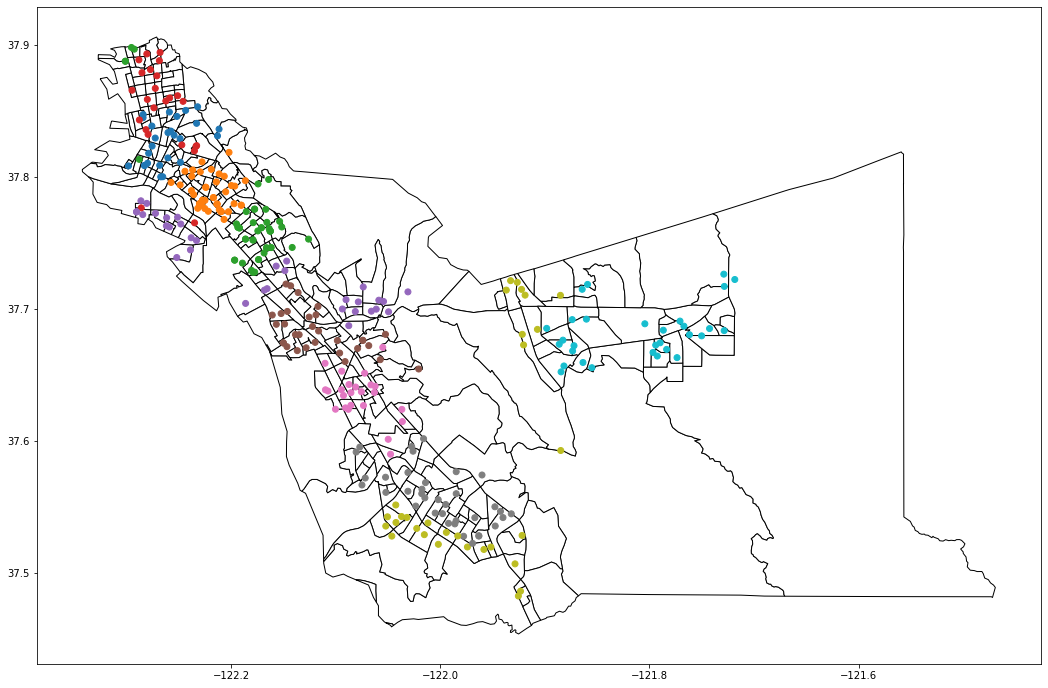

In [33]:
ax = tracts_acs_gdf_ac.plot(color='white', edgecolor='black', figsize=[18,18])
schools_jointracts.plot(column='GEOID', ax=ax)

### Assessing the Relationship between Median Household Income and API

Fantastic! That looks right!

Now we can create that scatterplot we were thinking about!

Text(0, 0.5, 'API')

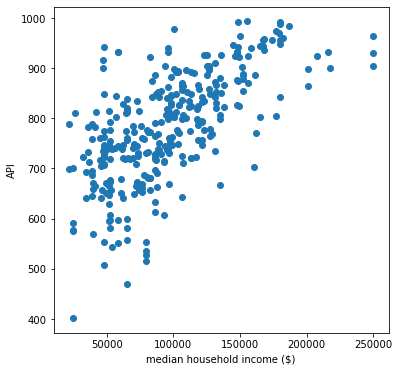

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(schools_jointracts.med_hhinc, schools_jointracts.API)
ax.set_xlabel('median household income ($)')
ax.set_ylabel('API')

Wow! Just as we suspected based on our overlay map,
there's a pretty obvious, strong, and positive correlation
between median household income in a school's tract
and the school's API.

# 7.3: Aggregation

We just saw that a spatial join in one way to leverage the spatial relationship
between two datasets in order to create a new, synthetic dataset.

An **aggregation** is another way we can generate new data from this relationship.
In this case, for each feature in one dataset we find all the features in another
dataset that satisfy our chosen spatial relationship query with it (e.g. within, intersects),
then aggregate them using some summary function (e.g. count, mean).

------------------------------------

### Getting the Aggregated School Counts

Let's take this for a spin with our data. We'll count all the schools within each census tract.

Note that we've already done the first step of spatially joining the data from the aggregating features
(the tracts) onto the data to be aggregated (our schools).

The next step is to group our GeoDataFrame by census tract, and then summarize our data by group.
We do this using the DataFrame method `groupy`.

To get the correct count, lets rejoin our schools on our tracts, this time keeping all schools
(not just those with APIs > 0, as before).

In [35]:
schools_jointracts = gpd.sjoin(schools_gdf, tracts_acs_gdf_ac, how='left')

Now for the `groupy` operation.

**NOTE**: We could really use any column, since we're just taking a count. For now we'll just use the school names ('Site').

In [36]:
schools_countsbytract = schools_jointracts[['GEOID','Site']].groupby('GEOID', as_index=False).count()
print("Counts, rows and columns:", schools_countsbytract.shape)
print("Tracts, rows and columns:", tracts_acs_gdf_ac.shape)

# take a look at the data
schools_countsbytract.head()

Counts, rows and columns: (263, 2)
Tracts, rows and columns: (361, 54)


,GEOID,Site
0,06001400100,1
1,06001400200,1
2,06001400400,2
3,06001400500,1
4,06001400700,2


### Getting Tract Polygons with School Counts

The above `groupby` and `count` operations give us the counts we wanted.
- We have the 263 (of 361) census tracts that have at least one school
- We have the number of schools within each of those tracts

But the output of `groupby` is a plain DataFrame not a GeoDataFrame.

If we want a GeoDataFrame then we have two options:
1. We could join the `groupby` output to `tracts_acs_gdf_ac` by the attribute `GEOID`
or
2. We could start over, using the GeoDataFrame `dissolve` method, which we can think of as a spatial `groupby`. 


---------------------------

Since we already know how to do an attribute join, we'll do the `dissolve`!

First, let's run a new spatial join.

In [37]:
tracts_joinschools = gpd.sjoin(schools_gdf, tracts_acs_gdf_ac, how='right')

Now, let's run our dissolve!

In [38]:
tracts_schoolcounts = tracts_joinschools[['GEOID', 'Site', 'geometry']].dissolve(by='GEOID', aggfunc='count')
print("Counts, rows and columns:", tracts_schoolcounts.shape)

# take a look
tracts_schoolcounts.head()

Counts, rows and columns: (361, 2)


,geometry,Site
GEOID,,
06001400100,"POLYGON ((-122.24692 37.88544, -122.24197 37.8...",1
06001400200,"POLYGON ((-122.25742 37.84310, -122.25620 37.8...",1
06001400300,"POLYGON ((-122.26416 37.84000, -122.26186 37.8...",0
06001400400,"POLYGON ((-122.26180 37.84179, -122.26130 37.8...",2
06001400500,"POLYGON ((-122.26941 37.84811, -122.26891 37.8...",1


Nice! Let's break that down.

- The `dissolve` operation requires a geometry column and a grouping column (in our case, 'GEOID'). Any geometries within the **same group** will be dissolved if they have the same geometry or nested geometries. 
 
- The `aggfunc`, or aggregation function, of the dissolve operation will be applied to all numeric columns in the input geodataframe (unless the function is `count` in which case it will count rows.)  

Check out the Geopandas documentation on [dissolve](https://geopandas.org/aggregation_with_dissolve.html?highlight=dissolve) for more information.


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. Above we selected three columns from the input GeoDataFrame to create a subset as input to the dissolve operation. Why?
1. Why did we run a new spatial join? What would have happened if we had used the `schools_jointracts` object instead?
1. What explains the dimensions of the new object (361, 2)?

### Mapping our Spatial Join Output

Also, because our `sjoin` plus `dissolve` pipeline outputs a GeoDataFrame, we can now easily map the school count by census tract!

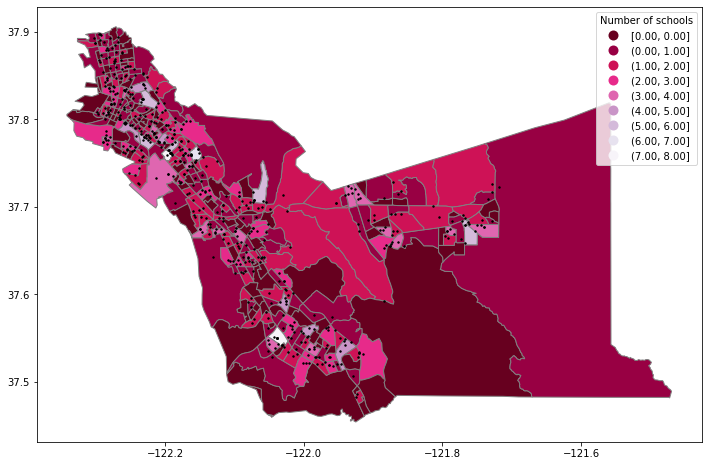

In [39]:
fig, ax = plt.subplots(figsize = (14,8)) 

# Display the output of our spatial join
tracts_schoolcounts.plot(ax=ax,column='Site', 
                         scheme="user_defined",
                         classification_kwds={'bins':[*range(9)]},
                         cmap="PuRd_r",
                         edgecolor="grey",
                         legend=True, 
                         legend_kwds={'title':'Number of schools'})
schools_gdf.plot(ax=ax, color='black', markersize=2)

---------------------

# Exercise: Aggregation

#### What is the mean API of each census tract?

As we mentioned, the spatial aggregation workflow that we just put together above
could have been used not to generate a new count variable, but also
to generate any other new variable the results from calling an aggregation function
on an attribute column.

In this case, we want to calculate and map the mean API of the schools in each census tract.

Copy and paste code from above where useful, then tweak and/or add to that code such that your new code:
1. joins the schools onto the tracts (**HINT**: make sure to decide whether or not you want to include schools with API = 0!)
1. dissolves that joined object by the tract IDs, giving you a new GeoDataFrame with each tract's mean API (**HINT**: because this is now a different calculation, different problems may arise and need handling!)
1. plots the tracts, colored by API scores (**HINT**: overlay the schools points again, visualizing them in a way that will help you visually check your results!)


Your resulting map should look something like the map we provide below.

**To see the solution, click the button.**

In [40]:
# YOUR CODE HERE:






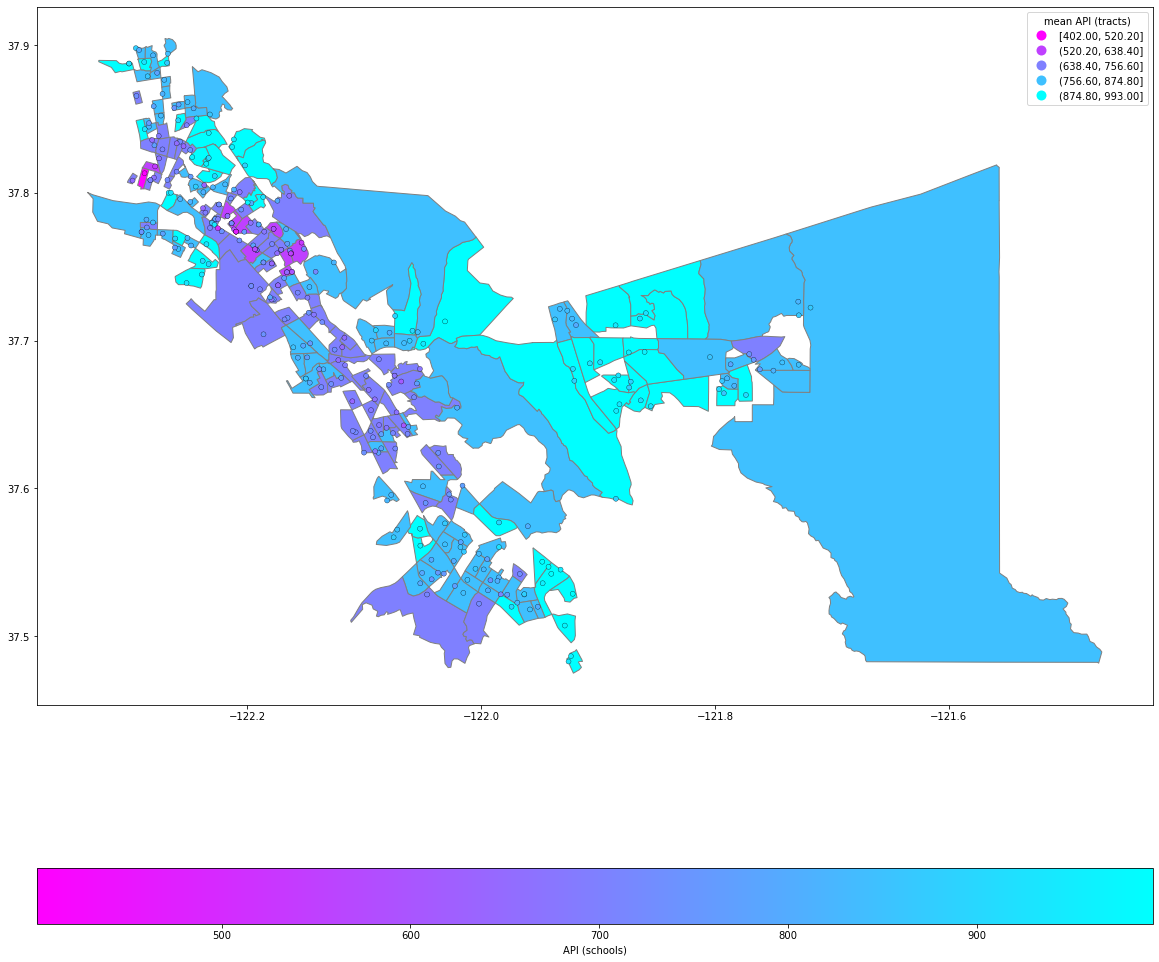

In [42]:
# SOLUTION:

# join the schools onto the tracks (excluding 0-API schools so that they don't skew our results!)
tracts_joinschools_api = gpd.sjoin(schools_gdf_api, tracts_acs_gdf_ac, how='right')

# dissolve the tracts by GEOID, using 'API' as the column we'll aggregate and 'mean' as our aggfunc
tracts_meanAPI = tracts_joinschools_api[['GEOID', 'API', 'geometry']].dropna(how='any').dissolve(by='GEOID',
                                                                                                 aggfunc='mean')

# plot the tracts, coloring them by mean API
fig, ax = plt.subplots(figsize = (20,20)) 
tracts_meanAPI.plot(ax=ax,column='API', 
                    scheme='equalinterval',
                    cmap="cool_r",
                    edgecolor="grey",
                    legend=True, legend_kwds={'title': 'mean API (tracts)'})
# add the schools, coloring them by API (so we can check that the mean APIs we calculated are resonable)
schools_gdf_api.plot(ax=ax, column='API', cmap='cool_r', edgecolor='black', linewidth=0.3, markersize=25,
                 legend=True, legend_kwds={'label': "API (schools)", 'orientation': "horizontal"})

hide_solution()

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


